(content:executable:output-insert)=
# Store code outputs and insert into content

You often wish to run analyses in one notebook and insert them in your
documents elsewhere. For example, if you'd like to include a figure,
or if you want to cite an analysis that you have run.

```{warning}
Currently, `glue` only works with Python.
```

```{seealso}
There have been changes in `jupyter-book>=0.14` in the way `glue`
works. Please [see this page for more details](explain:migration).

One of the major updates is that `glue` references between documents
now require to use `:doc:`. An example is [available here](explain:migration:glue)

```

The `glue` tool from [MyST-NB](https://myst-nb.readthedocs.io/)
allows you to add a key to variables in a notebook,
then display those variables in your book by referencing the key.

It follows a two-step process:

* **Glue a variable to a name**. Do this by using
  the `myst_nb.glue` function on a variable
  that you'd like to reuse elsewhere in the book. You'll give the variable
  a name that can be referenced later.
* **Reference that variable from your page's content**. Then, when you are
  writing your content, insert the variable into your text by using a
  `{glue:}` role.

We'll cover each step in more detail below.

:::{margin}
For more information about roles, see [](../myst.md).
:::

(glue/gluing)=
## Gluing variables in your notebook

You can use `myst_nb.glue()` to assign the value of a variable to
a key of your choice. `glue` will store all of the information that is normally used to **display**
that variable (i.e., whatever happens when you display the variable by putting it at the end of a
code cell). Choose a key that you will remember, as you will use it later.

The following code glues a variable inside the notebook to the key `"cool_text"`:

In [1]:
from myst_nb import glue
my_variable = "here is some text!"
glue("cool_text", my_variable)

'here is some text!'

You can then insert it into your text. Adding
`` {glue:}`cool_text` `` to your content results in the
following: {glue:}`cool_text`.

### Gluing numbers, plots, math, and tables

You can glue anything in your notebook (or page) and display it later with `{glue:}`. Here
we'll show how to glue and paste **numbers and images**. We'll simulate some
data and run a simple bootstrap on it. We'll hide most of this process below,
to focus on the glueing part.

In [2]:
# Simulate some data and bootstrap the mean of the data
import numpy as np
np.set_printoptions(legacy="1.25")

import pandas as pd
import matplotlib.pyplot as plt

n_points = 10000
n_boots = 1000
mean, sd = (3, .2)
data = sd*np.random.randn(n_points) + mean
bootstrap_indices = np.random.randint(0, n_points, n_points*n_boots).reshape((n_boots, n_points))

In the cell below, `data` contains our data, and `bootstrap_indices` is a collection of sample indices in each bootstrap. Below we'll calculate a few statistics of interest, and
**`glue()`** them into the notebook.

In [3]:
# Calculate the mean of a bunch of random samples
means = data[bootstrap_indices].mean(0)
# Calculate the 95% confidence interval for the mean
clo, chi = np.percentile(means, [2.5, 97.5])

# Store the values in our notebook
glue("boot_mean", means.mean())
glue("boot_clo", clo)
glue("boot_chi", chi)

2.9992157429488953

2.9869874875725233

3.0118174904652317

By default, `glue` will display the value of the variable you are gluing. This
is useful for sanity-checking its value at glue-time. If you'd like to **prevent display**,
use the `display=False` option. Note that below, we also *overwrite* the value of
`boot_chi` (but using the same value):

In [4]:
glue("boot_chi_notdisplayed", chi, display=False)

You can also glue visualizations, such as Matplotlib figures (here we use `display=False` to ensure that the figure isn't plotted twice):

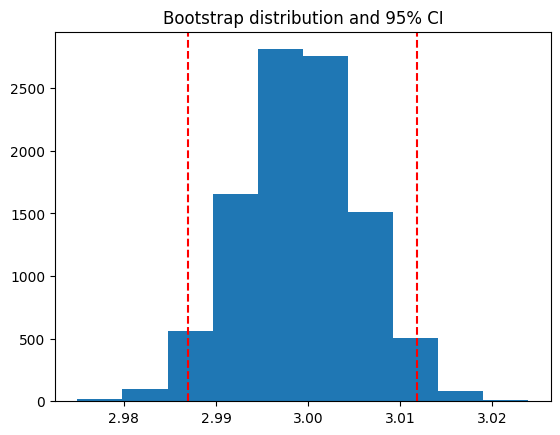

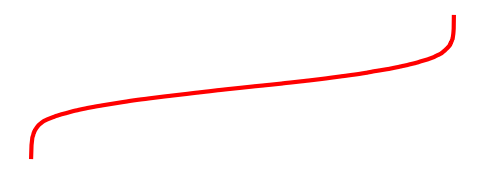

In [5]:
# Visualize the histogram with the intervals
fig, ax = plt.subplots()
ax.hist(means)
for ln in [clo, chi]:
    ax.axvline(ln, ls='--', c='r')
ax.set_title("Bootstrap distribution and 95% CI")

# And a wider figure to show a timeseries
fig2, ax = plt.subplots(figsize=(6, 2))
ax.plot(np.sort(means), lw=3, c='r')
ax.set_axis_off()

glue("boot_fig", fig, display=False)
glue("sorted_means_fig", fig2, display=False)

The same can be done for `DataFrame`s (or other table-like objects) as well.

In [6]:
bootstrap_subsets = data[bootstrap_indices][:3, :5].T
df = pd.DataFrame(bootstrap_subsets, columns=["first", "second", "third"])
glue("df_tbl", df)

,first,second,third
0,3.290708,3.306197,3.097848
1,3.069130,3.402096,2.982184
2,3.261156,3.024523,2.833675
3,2.769661,2.876694,2.977391
4,2.799777,2.882243,3.065218


```{tip}
Since we are going to paste this figure into our document at a later point,
you may wish to remove the output here, using the `remove-output` tag
(see {ref}`hiding/remove-content`).
```

(glue/pasting)=

## Pasting glued variables into your page

Once you have glued variables to their names, you can then **paste**
those variables into your text in your book anywhere you like (even on other pages).
These variables can be pasted using one of the roles or directives in the `glue` *family*.

### The `glue` role/directive

The simplest role and directive is `glue:any`,
which pastes the glued output in-line or as a block respectively,
with no additional formatting.
Simply add this:

````
```{glue:} your-key
```
````

For example, we'll paste the plot we generated above with the following text:

````md
```{glue:} boot_fig
```
````

Here's how it looks:

```{glue:} boot_fig
```

Or we can paste in-line objects like so:

```md
In-line text; {glue:}`boot_mean`, and a figure: {glue:}`boot_fig`.
```

In-line text; {glue:}`boot_mean`, and a figure: {glue:}`boot_fig`.

```{tip}
We recommend using wider, shorter figures when plotting in-line, with a ratio
around 6x2. For example, here's an in-line figure of sorted means
from our bootstrap: {glue:}`sorted_means_fig`.
It can be used to make a visual point that isn't too complex! For more
ideas, check out [how sparklines are used](https://en.wikipedia.org/wiki/Sparkline).
```

Next we'll cover some more specific pasting functionality, which gives you more
control over how the pasted outputs look in your pages.

## Controlling the pasted outputs

You can control the pasted outputs by using a sub-command of `{glue:}`. These are used like so:
`` {glue:subcommand}`key` ``. These subcommands allow you to control more of the look, feel, and
content of the pasted output.

```{tip}
When you use `{glue:}` you are actually using shorthand for `{glue:any}`. This is a
generic command that doesn't make many assumptions about what you are gluing.
```

### The `glue:text` role

The `glue:text` role is specific to text outputs.
For example, the following text:

```md
The mean of the bootstrapped distribution was {glue:text}`boot_mean` (95% confidence interval {glue:text}`boot_clo`/{glue:text}`boot_chi`).
```

Is rendered as:
The mean of the bootstrapped distribution was {glue:text}`boot_mean` (95% confidence interval {glue:text}`boot_clo`/{glue:text}`boot_chi`)

```{note}
`glue:text` only works with glued variables that contain a `text/plain` output.
```

With `glue:text` we can **add formatting to the output**.
This is particularly useful if you are displaying numbers and
want to round the results. To add formatting, use this syntax:

* `` {glue:text}`mykey:formatstring` ``

For example, ``My rounded mean: {glue:text}`boot_mean:.2f` `` will be rendered like this: My rounded mean: {glue:text}`boot_mean:.2f` (95% CI: {glue:text}`boot_clo:.2f`/{glue:text}`boot_chi:.2f`).

### The `glue:figure` directive

With `glue:figure` you can apply more formatting to figure-like objects,
such as giving them a caption and referenceable label. For example,

````md
```{glue:figure} boot_fig
:figwidth: 300px
:name: "fig-boot"

This is a **caption**, with an embedded `{glue:text}` element: {glue:text}`boot_mean:.2f`!
```
````

produces the following figure:

```{glue:figure} boot_fig
:figwidth: 300px
:name: "fig-boot"

This is a **caption**, with an embedded `{glue:text}` element: {glue:text}`boot_mean:.2f`!
```

Later, the code

```md
Here is a {ref}`reference to the figure <fig-boot>`
```

can be used to reference the figure.

Here is a {ref}`reference to the figure <fig-boot>`

Here's a table:

````md
```{glue:figure} df_tbl
:figwidth: 300px
:name: "tbl:df"

A caption for a pandas table.
```

````

which gets rendered as

```{glue:figure} df_tbl
:figwidth: 300px
:name: "tbl:df"

A caption for a pandas table.
```

### The `glue:math` directive

The `glue:math` directive is specific to LaTeX math outputs
(glued variables that contain a `text/latex` MIME type),
and works similarly to the [Sphinx math directive](https://www.sphinx-doc.org/en/1.8/usage/restructuredtext/directives.html#math).
For example, with this code we glue an equation:

In [7]:
import sympy as sym
f = sym.Function('f')
y = sym.Function('y')
n = sym.symbols(r'\alpha')
f = y(n)-2*y(n-1/sym.pi)-5*y(n-2)
glue("sym_eq", sym.rsolve(f,y(n),[1,4]))

ModuleNotFoundError: No module named 'sympy'

and now we can use the following code:

````md
```{glue:math} sym_eq
:label: eq-sym
```
````

to insert the equation here:

```{glue:math} sym_eq
:label: eq-sym
```

% TODO: figure out why this isn't working
% Which we then reference as Equation {eq}`eq-sym`.

```{note}
`glue:math` only works with glued variables that contain a `text/latex` output.
```

## Advanced `glue` use-cases

Here are a few more specific and advanced uses of the `glue` submodule.

### Pasting into tables

In addition to pasting blocks of outputs, or in-line with text, you can also paste directly
into tables. This allows you to compose complex collections of structured data using outputs
that were generated in other cells or other notebooks. For example, the following Markdown table:

````md
| name                            |       plot                    | mean                      | ci                                                |
|:-------------------------------:|:-----------------------------:|---------------------------|---------------------------------------------------|
| histogram and raw text          | {glue:}`boot_fig`             | {glue:}`boot_mean`          | {glue:}`boot_clo`-{glue:}`boot_chi`                   |
| sorted means and formatted text | {glue:}`sorted_means_fig`     | {glue:text}`boot_mean:.3f` | {glue:text}`boot_clo:.3f`-{glue:text}`boot_chi:.3f` |
````

Results in:

| name                            |       plot                  | mean                      | ci                                                |
|:-------------------------------:|:---------------------------:|---------------------------|---------------------------------------------------|
| histogram and raw text          | {glue:}`boot_fig`             | {glue:}`boot_mean`          | {glue:}`boot_clo`-{glue:}`boot_chi`                   |
| sorted means and formatted text | {glue:}`sorted_means_fig`     | {glue:text}`boot_mean:.3f` | {glue:text}`boot_clo:.3f`-{glue:text}`boot_chi:.3f` |